# GuestEnv Scenario Tests

This notebook runs the GuestEnv environment in five different scenarios. Each scenario logs phonemes per agent and rewards, then plots the results.

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('..'))
from env.env_gym import GuestEnv

In [2]:
def run_env(env, actions, steps=200, seed=42):
    obs, info = env.reset(seed=seed)
    phonemes, rewards = [], []
    for i in range(steps):
        act = actions[i] if i < len(actions) else actions[-1]
        obs, reward, terminated, truncated, info = env.step(act)
        phonemes.append(info['phoneme'].copy())
        rewards.append(reward)
        if terminated or truncated:
            break
    return np.array(phonemes), np.array(rewards)

def plot_results(phonemes, rewards, title):
    steps = np.arange(len(rewards))
    plt.figure(figsize=(9,4))
    for a in range(phonemes.shape[1]):
        plt.plot(steps, phonemes[:, a], label=f'Agent {a}')
    plt.xlabel('Step'); plt.ylabel('Phonemes'); plt.title(title + ' - Phonemes')
    plt.legend(); plt.grid(True); plt.show()
    plt.figure(figsize=(9,4))
    plt.plot(steps, rewards, label='Reward')
    plt.xlabel('Step'); plt.ylabel('Reward'); plt.title(title + ' - Reward')
    plt.grid(True); plt.show()

## Scenario 1: Baseline
No guest actions are taken.

In [3]:
env = GuestEnv(max_steps=200, reward_shaping=False)
env.agent_params[0].update({'min_energy_to_speak':0.6,'energy_gain':0.01,'energy_decay':0.15,'max_speaking_time':2,'phonemes_per_step':1})
env.agent_params[1].update({'min_energy_to_speak':0.3,'energy_gain':0.05,'energy_decay':0.10,'max_speaking_time':5,'phonemes_per_step':2})
env.agent_params[2].update({'min_energy_to_speak':0.1,'energy_gain':0.10,'energy_decay':0.05,'max_speaking_time':8,'phonemes_per_step':4})
actions = [0]*200
ph, rw = run_env(env, actions)

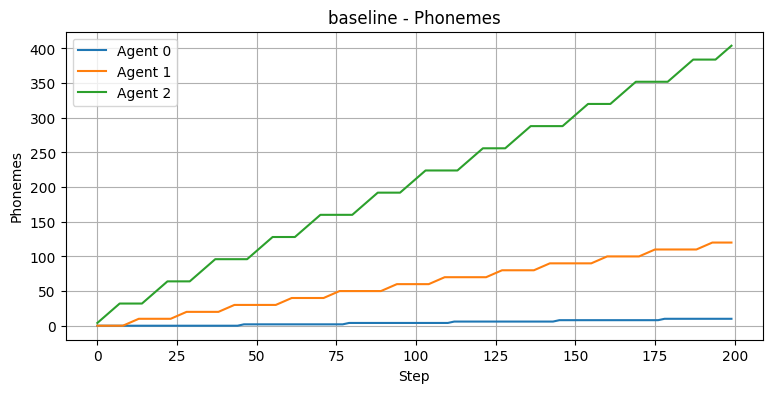

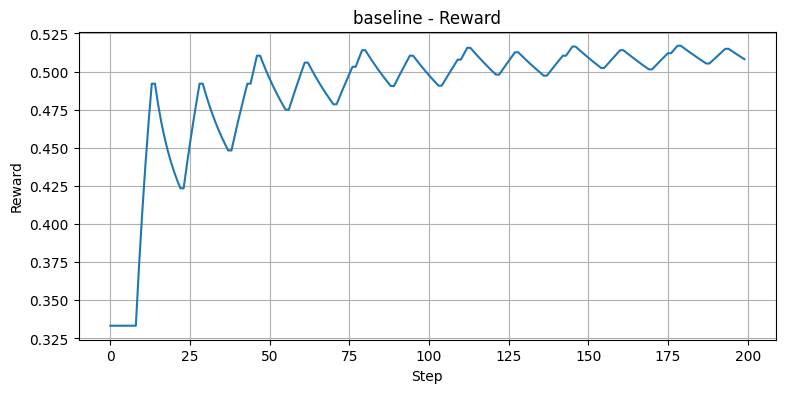

In [4]:
plot_results(ph, rw, 'baseline')

In [5]:
obs = []
energy = [1,2,3]
speaking = [4,5,6]
phonemes= [7.2,8.2,9.2]
for i in range(3):
    obs.extend([
        energy[i],
        speaking[i],
        phonemes[i],
    ])
r = np.asarray(obs, dtype=np.float32)
print(r)

[1.  4.  7.2 2.  5.  8.2 3.  6.  9.2]


In [6]:
rng = np.random.default_rng(45)
for i in range(1):
    print(rng.uniform(0.3, 0.7, size=3))

[0.52925226 0.51139646 0.6054601 ]
